In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install git+https://github.com/surmenok/keras_lr_finder

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-224zoz_d
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-224zoz_d
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1697250458.234461280913877459770598239055499887507454304677-py3-none-any.whl size=301568 sha256=dd62702383d9866ada3aceb194c3f6adc86020db9c3637b330cdf75055574b68
  Stored in directory: /tmp/pip-ephem-wheel-cache-73ebkl7f/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Successfully built tensorflow-examples
  Cloning https://github.com/surmenok/keras_lr_finder to /tmp/pip-req-build-s7ns_pop
  Running command git clone -q https://github.com/surmenok/keras_lr_finder /tmp/pip-req-build-s7ns_pop
  Created wheel for keras-lr-finder: filename=keras_lr_finder-0.1-py3-none-any.whl size=4001 sha256=caab3ef5d7259ff68e448a6dbe7eaad6b31c9a3d3b6335eaee80d305b2dfe71a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ed77zio5/whee

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix
from keras_lr_finder import LRFinder
from tensorflow import keras

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

In [4]:
def Read_All_Data(path):
    temp = []
    updated_path = os.path.join(path,"VOC2012","ImageSets","Segmentation","trainval.txt")
    with open(updated_path,"r") as file_:
        Instances = file_.read().split()
        img_arr = []
        seg_arr = []
        for img in Instances:
            path_img = os.path.join(path,"VOC2012","JPEGImages",img+".jpg")
            path_seg = os.path.join(path,"VOC2012","SegmentationClass",img+".png")
            img = np.array(Image.open(path_img).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg = np.array(Image.open(path_seg).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg[seg == 255] = 21
            img_arr.append(img)
            seg_arr.append(seg)
    return np.array(img_arr), np.array(seg_arr)

In [5]:
path = "../input/pascal-voc-2012"
full_dataset = tf.data.Dataset.from_tensor_slices(Read_All_Data(path))

In [6]:
DATASET_SIZE = 2913

In [7]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size = DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [8]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

### We need some agumentation while loading the training set in order to prevent overfitting 

In [9]:
def load_image_train(input_image, input_mask):
    input_mask = input_mask[ ..., np.newaxis]
    

    # random flip the image and mask
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_mask = input_mask[:, :, 0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [10]:
def load_image_test(input_image, input_mask):
    input_mask = input_mask[np.newaxis, ...]
    
    
    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [11]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE

In [12]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val   = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [13]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

### show an example of image and mask

(256, 256, 3)


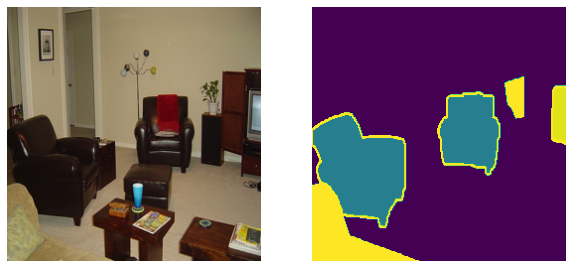

(256, 256, 3)


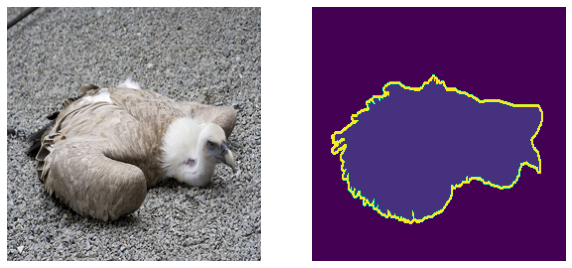

In [24]:
for image, mask in train.take(2):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    sample_image, sample_mask = image, mask
    axes[0].imshow(sample_image)
    axes[0].axis('off')
    
    print(sample_image.shape)
   
    axes[1].imshow(sample_mask)
    axes[1].axis('off')

    plt.show()

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# use the output of listed layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# build the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
# we'll not change the parameter of the decoder
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [26]:
# build the upsampling model (decoder)
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [27]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    # downsampling and extract features 
    skips = down_stack(x)
    x = skips[-1]
    # layers to establish skip connections in the encoder model
    skips = reversed(skips[:-1])

    # establish skip connections between layers of encoder and decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # the last layer 
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### find the optimal learning rate

In [28]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### From the above figure, 1e-4 is the optimal learning rate

In [29]:
optimizer = keras.optimizers.Adam(lr=1e-4)

In [30]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

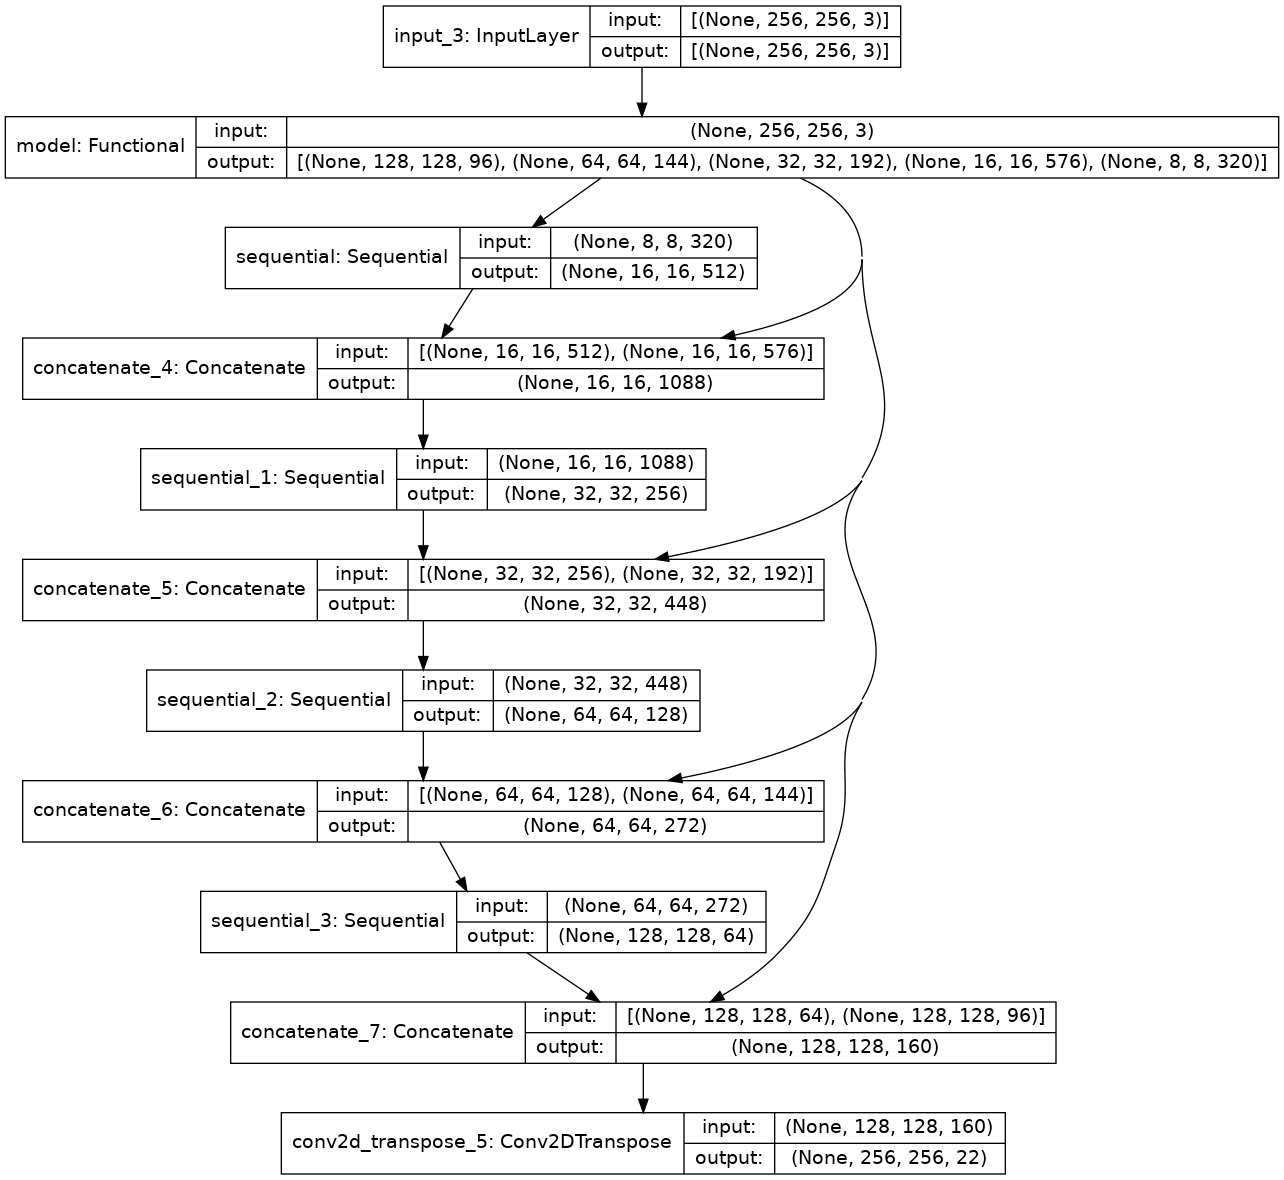

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [34]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)

Epoch 1/30
63/63 [==============================] - 30s 315ms/step - loss: 3.1465 - accuracy: 0.1628 - val_loss: 1.8650 - val_accuracy: 0.6456
Epoch 2/30
63/63 [==============================] - 19s 286ms/step - loss: 1.5182 - accuracy: 0.6924 - val_loss: 1.3278 - val_accuracy: 0.7051
Epoch 3/30
63/63 [==============================] - 18s 291ms/step - loss: 1.2685 - accuracy: 0.6996 - val_loss: 1.4640 - val_accuracy: 0.6510
Epoch 4/30
63/63 [==============================] - 18s 279ms/step - loss: 1.1571 - accuracy: 0.7138 - val_loss: 1.1765 - val_accuracy: 0.7074
Epoch 5/30
63/63 [==============================] - 18s 280ms/step - loss: 1.0778 - accuracy: 0.7253 - val_loss: 1.0425 - val_accuracy: 0.7257
Epoch 6/30
63/63 [==============================] - 18s 281ms/step - loss: 1.0031 - accuracy: 0.7399 - val_loss: 0.9263 - val_accuracy: 0.7551
Epoch 7/30
63/63 [==============================] - 18s 283ms/step - loss: 0.9635 - accuracy: 0.7470 - val_loss: 0.9361 - val_accuracy: 0.7508

In [36]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [37]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()

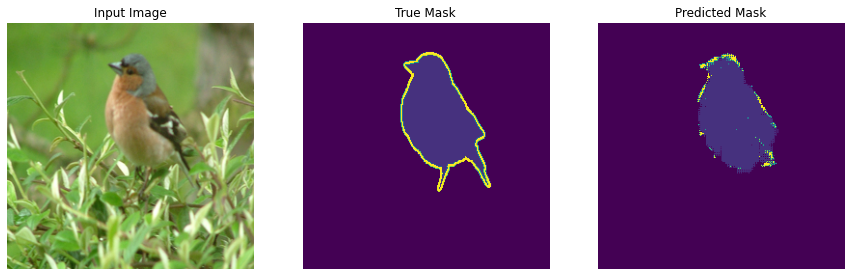

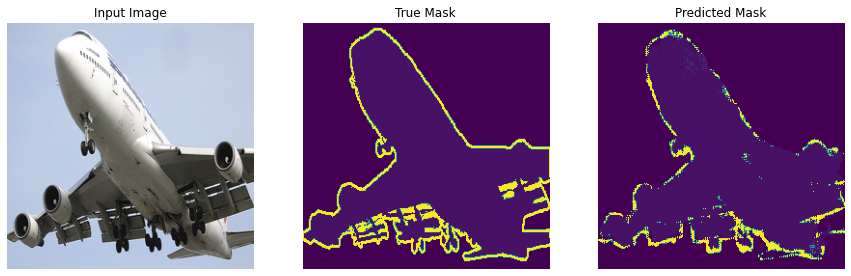

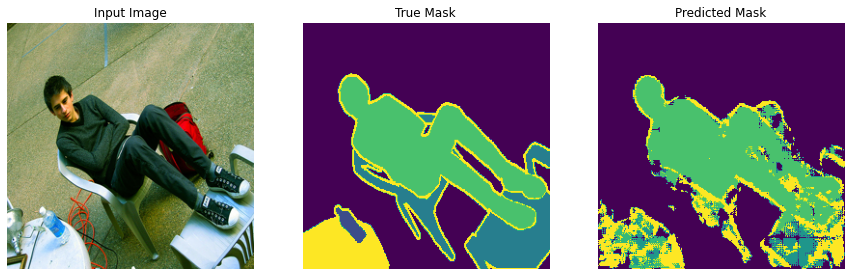

In [38]:
show_predictions(train_dataset, num =3)

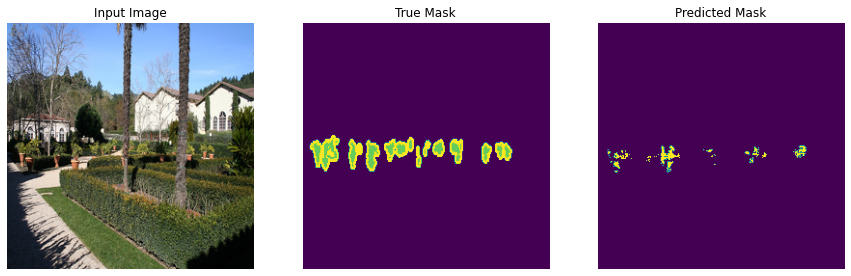

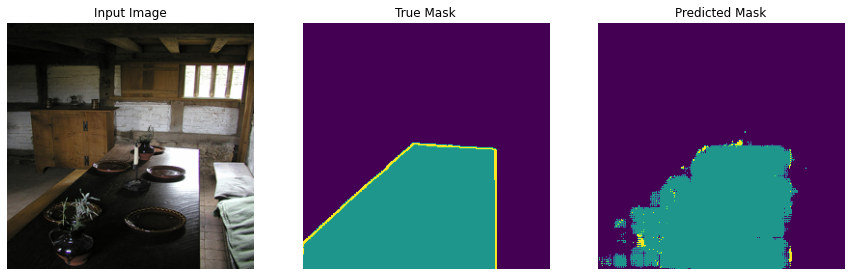

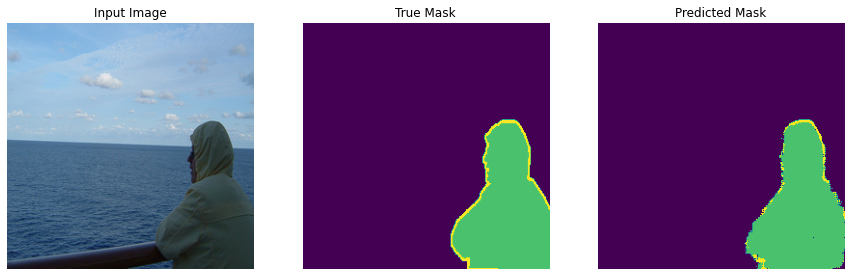

In [39]:
show_predictions(test_dataset.shuffle(buffer_size=64), num =3)

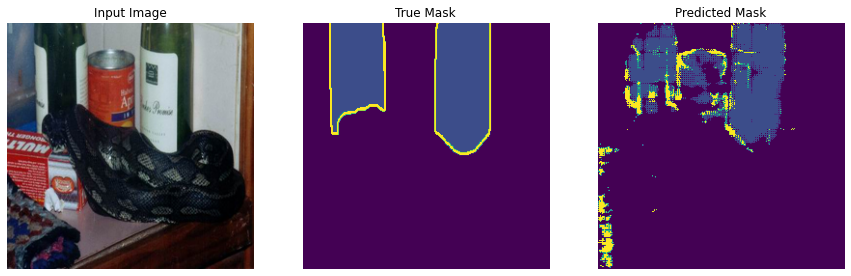

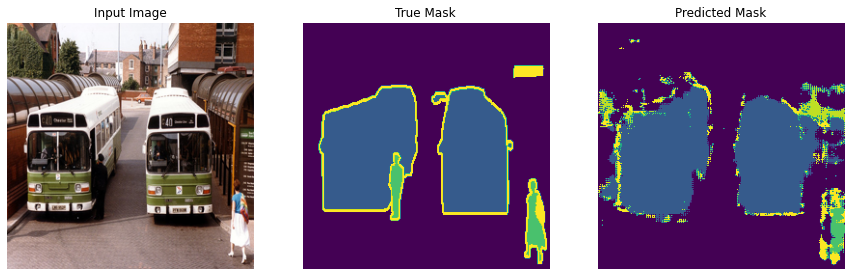

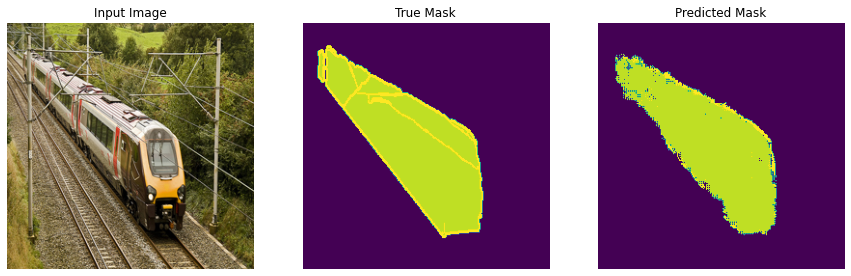

In [40]:
show_predictions(val_dataset.shuffle(buffer_size=64), num =3)

In [41]:
model.evaluate(test_dataset)

10/10 [==============================] - 3s 146ms/step - loss: 0.4104 - accuracy: 0.8853


[0.4104461073875427, 0.8852853775024414]

### Model inference and extract mask

In [42]:
!mkdir source
!mkdir mask

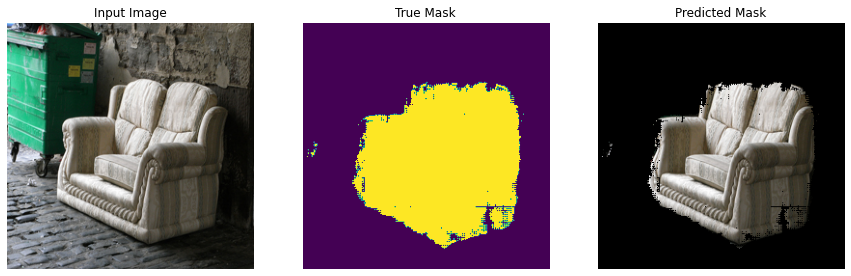

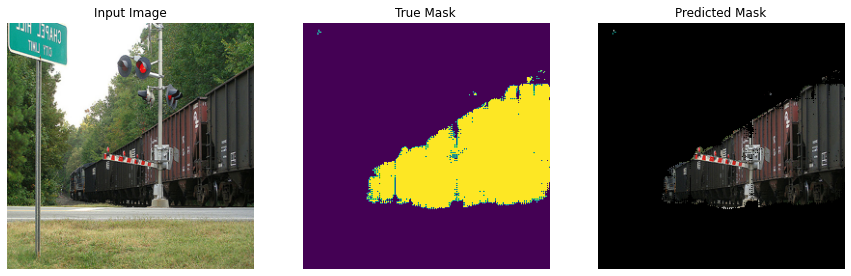

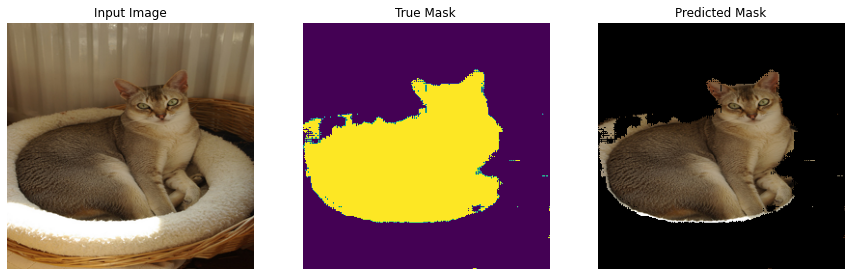

In [44]:
cnt = 0
for image, mask in train_dataset.take(3):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    pred_mask = (np.array(pred_mask) !=0).astype(int)
#     print(image[0].shape)
#     print(pred_mask.shape)
    Image.fromarray((np.array(image[0]*255).astype(np.uint8))).save(f"source/source_{cnt}.jpg")
    Image.fromarray((pred_mask[:,:,0]*255).astype(np.uint8)).save(f"mask/mask_{cnt}.jpg")
    display([image[0], pred_mask[:, :, 0], image[0] * pred_mask])
    cnt += 1